##Generating Shakespeare like text
Using a collection of shakespeare's sonnets we train a model which can generate shakespeare like text.
We use a simple LSTM.

In [1]:
!wget --no-check-certificate \
https://raw.githubusercontent.com/raziiiuddin/ml_practice/master/learn/shakespeare.txt \
-O /tmp/shakespeare.txt

--2020-10-03 14:43:43--  https://raw.githubusercontent.com/raziiiuddin/ml_practice/master/learn/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96745 (94K) [text/plain]
Saving to: ‘/tmp/shakespeare.txt’

/tmp/shakespeare.tx 100%[===================>]  94.48K  --.-KB/s    in 0.03s   

2020-10-03 14:43:44 (2.87 MB/s) - ‘/tmp/shakespeare.txt’ saved [96745/96745]



In [23]:
with open('/tmp/shakespeare.txt', 'r') as textfile:
    data = textfile.read()

text = data.lower().split('\n')
# Removing the heading and footer
sentences = text[4:-4]
sentences[:7]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou contracted to thine own bright eyes,',
 "feed'st thy light's flame with self-substantial fuel,",
 'making a famine where abundance lies,']

In [17]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
total_words = len(word_index) + 1

In [24]:
sequences = []
for sentence in sentences:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)

max_sequence_length = max([len(x) for x in sequences])

sequences[:7]

[[35, 412],
 [35, 412, 874],
 [35, 412, 874, 162],
 [35, 412, 874, 162, 213],
 [35, 412, 874, 162, 213, 507],
 [8, 875],
 [8, 875, 132]]

In [25]:
padded = pad_sequences(sequences, maxlen=max_sequence_length, padding="pre")

In [26]:
padded[:7]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 412],
       [  0,   0,   0,   0,   0,   0,   0,   0,  35, 412, 874],
       [  0,   0,   0,   0,   0,   0,   0,  35, 412, 874, 162],
       [  0,   0,   0,   0,   0,   0,  35, 412, 874, 162, 213],
       [  0,   0,   0,   0,   0,  35, 412, 874, 162, 213, 507],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   8, 875],
       [  0,   0,   0,   0,   0,   0,   0,   0,   8, 875, 132]],
      dtype=int32)

In [27]:
xs, labels = padded[:,:-1], padded[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [28]:
xs[:7]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  35],
       [  0,   0,   0,   0,   0,   0,   0,   0,  35, 412],
       [  0,   0,   0,   0,   0,   0,   0,  35, 412, 874],
       [  0,   0,   0,   0,   0,   0,  35, 412, 874, 162],
       [  0,   0,   0,   0,   0,  35, 412, 874, 162, 213],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   8],
       [  0,   0,   0,   0,   0,   0,   0,   0,   8, 875]], dtype=int32)

In [29]:
ys[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [33]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(total_words, 64, input_length=max_sequence_length-1),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(total_words, activation="softmax")
])

model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 64)            204672    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 3198)              412542    
Total params: 683,262
Trainable params: 683,262
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(xs, ys, epochs=50)

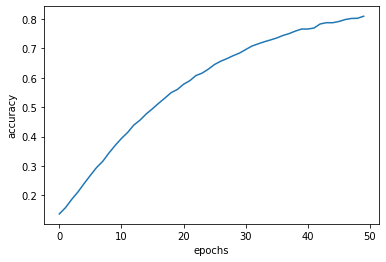

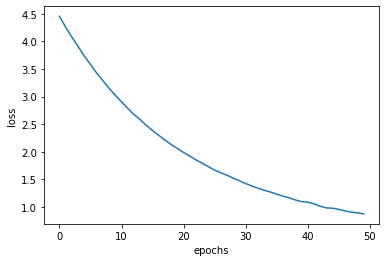

In [36]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [67]:
def generate_shakespeare_text(my_string):
    next_word = 88
    my_sequence = tokenizer.texts_to_sequences([my_string])
    reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

    for _ in range(next_word):
        token_list = tokenizer.texts_to_sequences([my_string])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding="pre")
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = reverse_word_index[int(predicted)]
        my_string += " " + output_word
    sonnet=[]
    # individual words from the string
    sonnet_string = [x for x in my_string.split(" ")]
    for i in range(1,6):
        sonnet.append(" ".join(s for s in sonnet_string[(i-1)*11:i*11]))
    return sonnet

In [73]:
strings = ["I love thee with all my heart", "Forsooth this maketh no sense",
           "Shall I compare thee to a summers day","Farewell thou art too deare"]
sonnets = [generate_shakespeare_text(s) for s in strings]
for sonnet in sonnets:
    for line in sonnet:
        print(line)
    print("-------------------------")

I love thee with all my heart i find then you
' made lies man live strangely near general of surmise state
doth kind ' praise apple are bright laid winter man deeds
bewailed stores to her friend ' ' old now now prove
none' dote gone ere thee benefit hide my sight to lie
-------------------------
Forsooth this maketh no sense of his society affords rehearse shine
bright peep man man more benefit living pain new awake bright
lies i chide thee be dead as time wherein her stars
in thee behold are near hence kill me new lameness and
i can mend them me be foes denote is away her
-------------------------
Shall I compare thee to a summers day to show decay
light now lie still thought doth thought it now you as
pitying me as i bold old truth shall know be thine
of true friend thrice and less truth and thee doth see
approve of good date still weeds bright red new fired lie
-------------------------
Farewell thou art too deare dear for my possessing name no
account mixed debarred the shore of lo

As you can see the model performs fairly well, if the model is trained for 100 epochs I think it will probably reach 90% accuracy. 